In [1]:
import pandas as pd

In [ ]:
# 데이터 로드
train = pd.read_csv('../data/train/train.csv')

train

,영업일자,영업장명_메뉴명,매출수량
0,2023-01-01,느티나무 셀프BBQ_1인 수저세트,0
1,2023-01-02,느티나무 셀프BBQ_1인 수저세트,0
2,2023-01-03,느티나무 셀프BBQ_1인 수저세트,0
3,2023-01-04,느티나무 셀프BBQ_1인 수저세트,0
4,2023-01-05,느티나무 셀프BBQ_1인 수저세트,0
...,...,...,...
102671,2024-06-11,화담숲카페_현미뻥스크림,12
102672,2024-06-12,화담숲카페_현미뻥스크림,10
102673,2024-06-13,화담숲카페_현미뻥스크림,14
102674,2024-06-14,화담숲카페_현미뻥스크림,12


In [ ]:
# 영업 일자
print(train['영업일자'].nunique()) # 532일

d = pd.to_datetime(train["영업일자"])
full = pd.date_range(d.min(), d.max(), freq="D")
missing = full.difference(pd.Index(d.unique()))

print(f"연속성 OK? {len(missing)==0}")
if len(missing): print("빠진 날짜:", list(missing)) # 빠진 날짜 없음

532
연속성 OK? True


In [ ]:
# 영업장별 메뉴 수
print(train['영업장명_메뉴명'].nunique()) # 193개

# '느티나무 셀프BBQ': 23
# '담하': 42
# '라그로타': 25
# '미라시아': 31
# '연회장': 23
# '카페테리아': 24
# '포레스트릿': 12
# '화담숲주막': 8
# '화담숲카페': 5

193


## Graph

In [ ]:
# 영업일자, 업장, 메뉴 분리
df = train.copy()
df["영업일자"] = pd.to_datetime(df["영업일자"])
sp = df["영업장명_메뉴명"].str.split("_", n=1, expand=True)
df["업장"] = sp[0]; df["메뉴"] = sp[1]

# 평일(월화수목)
df["is_weekday"] = df["영업일자"].dt.weekday < 4

# 고정일 공휴일(음력/대체공휴일 제외)
_fixed_mmdd = {"01-01","03-01","05-05","06-06","08-15","10-03","10-09","12-25"}
df["is_fixed_holiday"] = df["영업일자"].dt.strftime("%m-%d").isin(_fixed_mmdd)

day_flags = (
    df[["영업일자", "is_weekday", "is_fixed_holiday"]]
      .drop_duplicates()
      .sort_values("영업일자")
      .reset_index(drop=True)
)

df

,영업일자,영업장명_메뉴명,매출수량,업장,메뉴,is_weekday,is_fixed_holiday
0,2023-01-01,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트,False,True
1,2023-01-02,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트,True,False
2,2023-01-03,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트,True,False
3,2023-01-04,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트,True,False
4,2023-01-05,느티나무 셀프BBQ_1인 수저세트,0,느티나무 셀프BBQ,1인 수저세트,True,False
...,...,...,...,...,...,...,...
102671,2024-06-11,화담숲카페_현미뻥스크림,12,화담숲카페,현미뻥스크림,True,False
102672,2024-06-12,화담숲카페_현미뻥스크림,10,화담숲카페,현미뻥스크림,True,False
102673,2024-06-13,화담숲카페_현미뻥스크림,14,화담숲카페,현미뻥스크림,True,False
102674,2024-06-14,화담숲카페_현미뻥스크림,12,화담숲카페,현미뻥스크림,False,False


In [165]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rcParams
from matplotlib.ticker import MaxNLocator, StrMethodFormatter
from matplotlib.patches import Patch

# --- 폰트/크기 설정 ---
rcParams["font.family"] = "Malgun Gothic"
rcParams["axes.unicode_minus"] = False
rcParams["figure.figsize"] = (16, 4)

# --- 업장별 하드코딩 색상(빨강 제외) ---
venues = ["느티나무 셀프BBQ","담하","라그로타","미라시아","연회장","카페테리아","포레스트릿","화담숲주막","화담숲카페"]
HARD_COLORS = ["#1f77b4","#2ca02c","#ff7f0e","#9467bd","#8c564b","#17becf","#bcbd22","#7f7f7f","#66c2a5"]
VENUE_COLORS = {v: HARD_COLORS[i % len(HARD_COLORS)] for i, v in enumerate(venues)}
MA_COLOR = "red"  # 7일 이평선 공통 색상

# --- 배경 음영(평일/공휴일) 도우미: day_flags를 사용 ---
def shade_from_flags(ax, dates, flags_df,
                     weekday_color="#EFEFEF", weekday_alpha=1.0,
                     holiday_color="#FFE6E6", holiday_alpha=1.0):
    flags = (flags_df.set_index("영업일자")
                      .reindex(pd.to_datetime(dates))
                      .fillna(False)
                      .reset_index()
                      .rename(columns={"index":"영업일자"}))
    for _, r in flags.iterrows():
        d0 = r["영업일자"]
        d1 = d0 + pd.Timedelta(days=1)
        if r["is_weekday"]:
            ax.axvspan(d0, d1, facecolor=weekday_color, alpha=weekday_alpha, zorder=0)
        if r["is_fixed_holiday"]:
            ax.axvspan(d0, d1, facecolor=holiday_color, alpha=holiday_alpha, zorder=0)
    # 범례용 프록시
    return [Patch(facecolor=weekday_color, alpha=weekday_alpha, label="평일"),
            Patch(facecolor=holiday_color, alpha=holiday_alpha, label="고정 공휴일")]

# --- 업장별 플로팅 함수 ---
def plot_venue(venue, ma_color=MA_COLOR, figsize=(18,4)):
    items = df.loc[df["업장"] == venue, "영업장명_메뉴명"].dropna().unique()
    line_color = VENUE_COLORS.get(venue, "#000000")  # 매핑 없으면 검정

    for name in items:
        menu = name.split("_", 1)[1]
        ts = (df.loc[df["영업장명_메뉴명"] == name, ["영업일자","매출수량"]]
                .groupby("영업일자", as_index=False).sum()
                .sort_values("영업일자"))
        ts["매출수량"] = ts["매출수량"].fillna(0).astype("int64")
        ts["MA7"] = ts["매출수량"].rolling(7, min_periods=1).mean()

        plt.figure(figsize=figsize)
        ax = plt.gca()

        # --- 배경 음영(주말/고정 공휴일) ---
        bg_handles = shade_from_flags(ax, ts["영업일자"], day_flags)

        # --- 라인(일일/이평) ---
        plt.plot(ts["영업일자"], ts["매출수량"], label="일일 매출수량", color=line_color)
        plt.plot(ts["영업일자"], ts["MA7"], label="7일 이동평균", color=ma_color, linestyle="--", linewidth=2)

        # --- 축/레이블/범례 ---
        plt.title(f"[{venue}] {menu}")
        plt.xlabel("영업일자"); plt.ylabel("매출수량")

        loc = mdates.AutoDateLocator()
        ax.xaxis.set_major_locator(loc)
        ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(loc))
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.yaxis.set_major_formatter(StrMethodFormatter("{x:,.0f}"))

        line_handles, line_labels = ax.get_legend_handles_labels()
        plt.legend(handles=bg_handles + line_handles,
                   labels=["평일(월화수목)","공휴일"] + line_labels,
                   loc="best")
        plt.tight_layout(); plt.show()

        break # 테스트


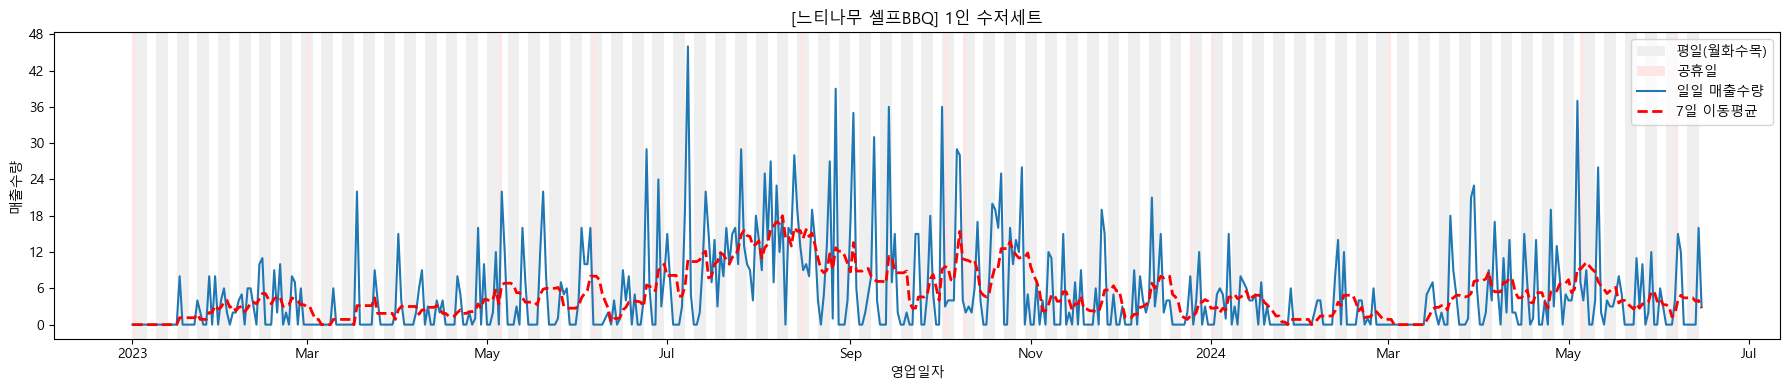

In [166]:
plot_venue("느티나무 셀프BBQ")

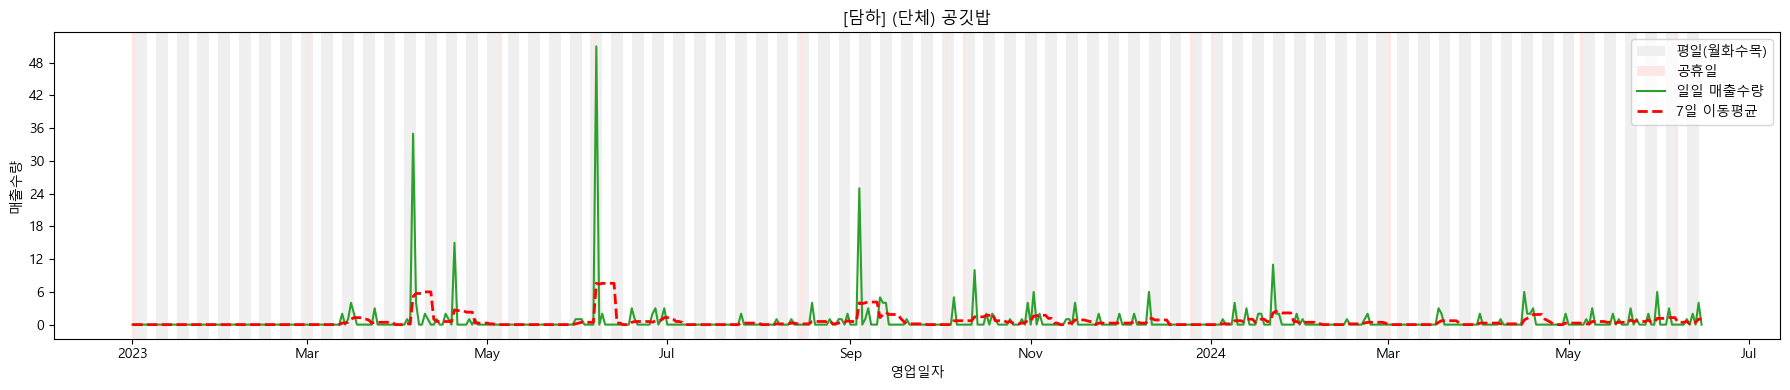

In [167]:
plot_venue("담하")

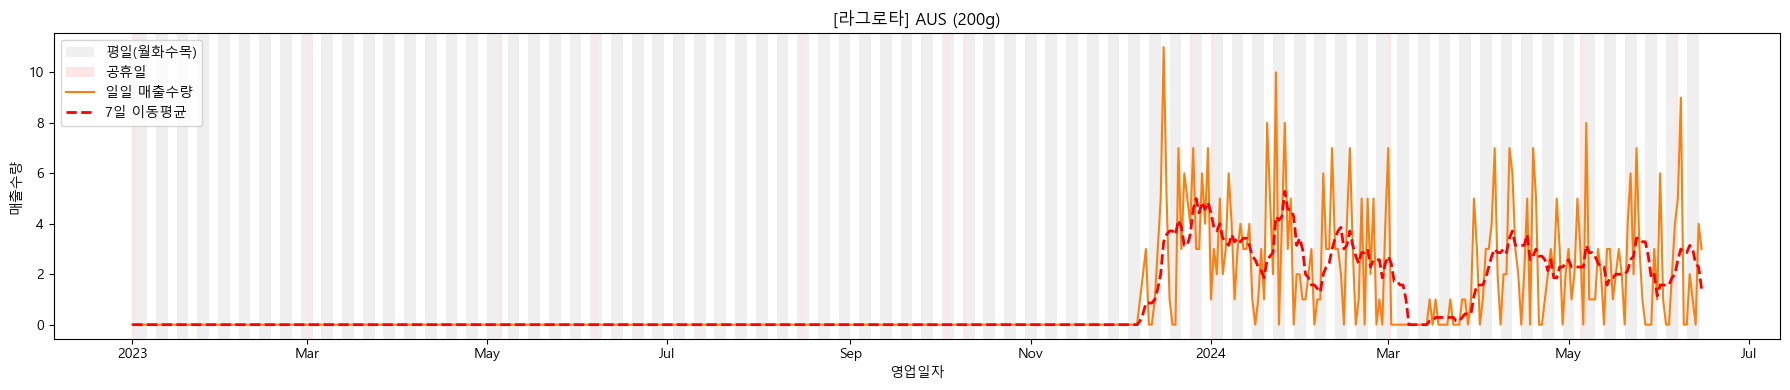

In [168]:
plot_venue("라그로타")

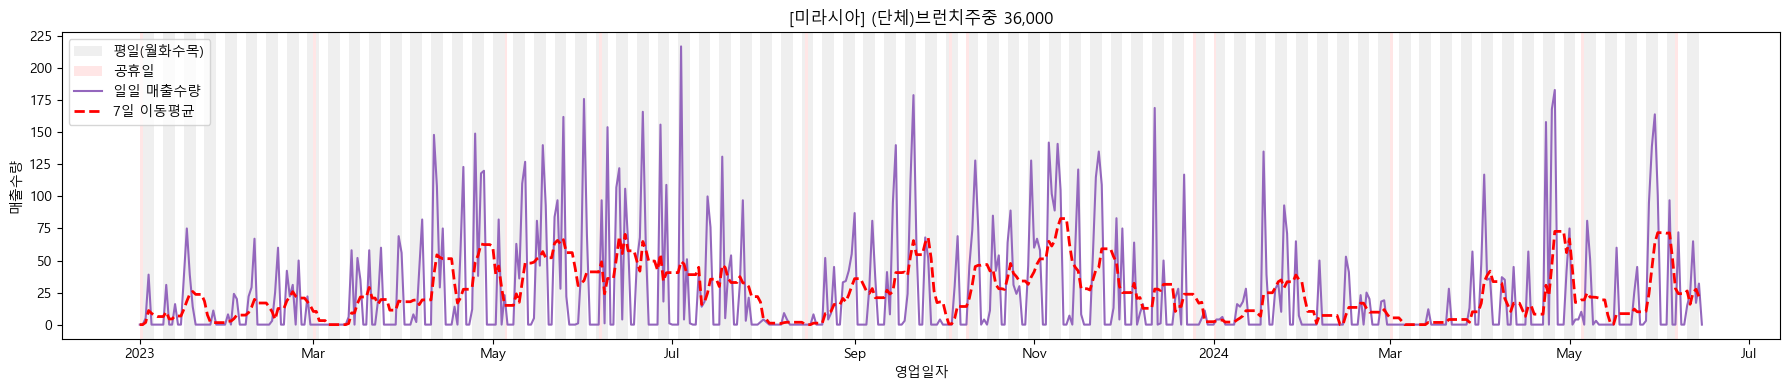

In [169]:
plot_venue("미라시아")

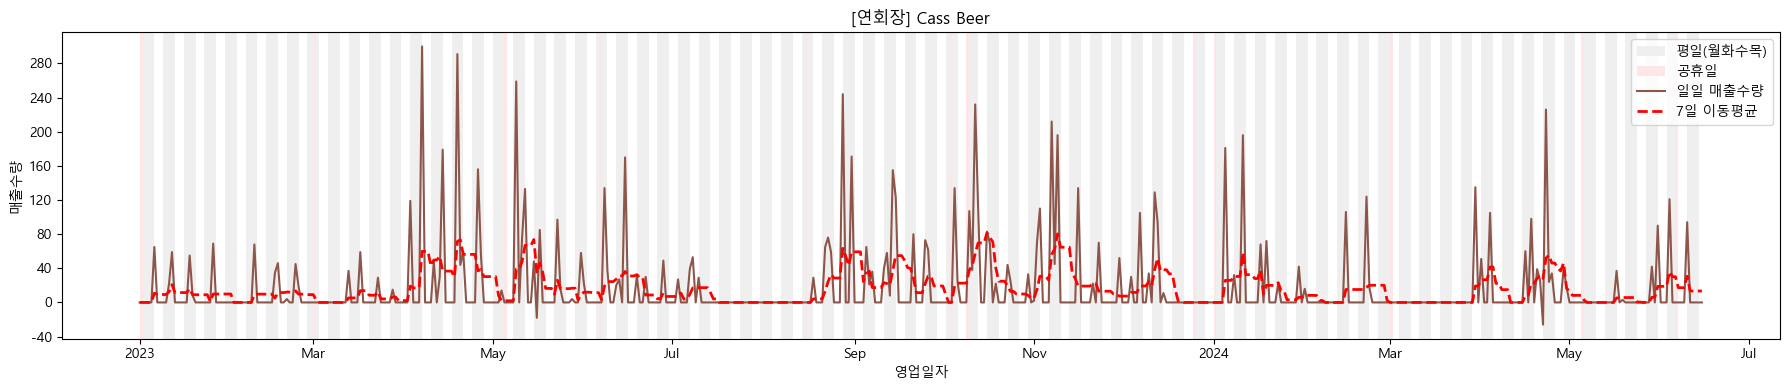

In [170]:
plot_venue("연회장")

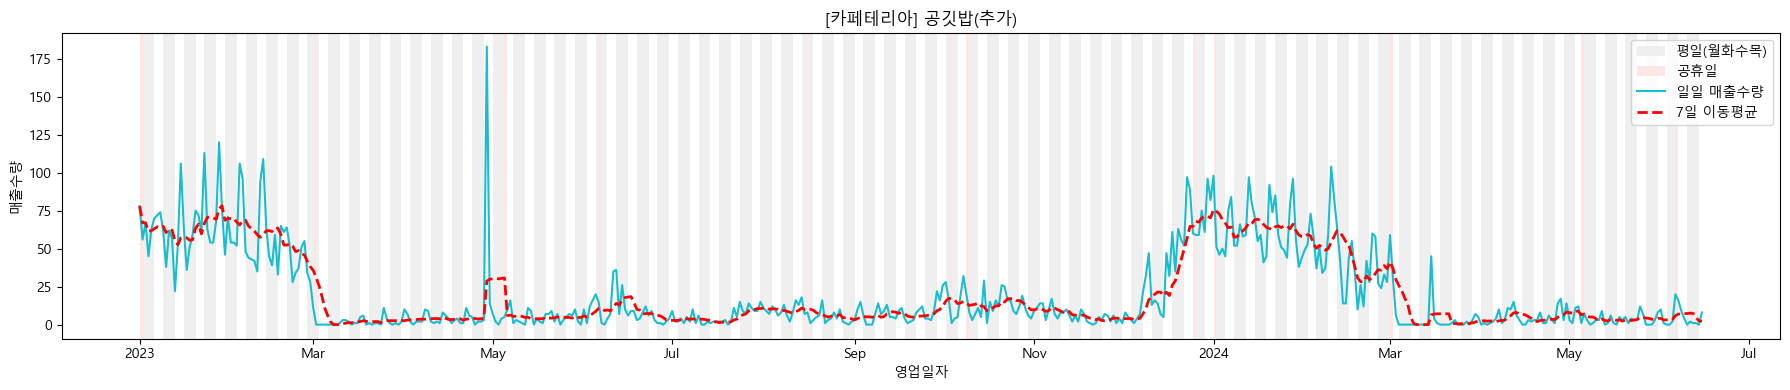

In [171]:
plot_venue("카페테리아")

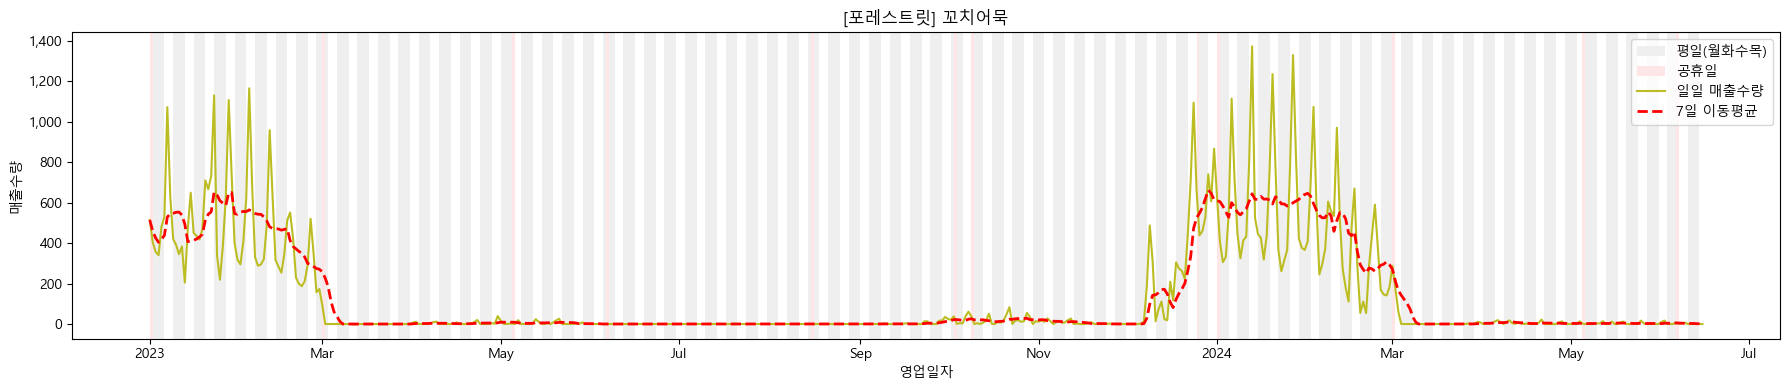

In [172]:
plot_venue("포레스트릿")

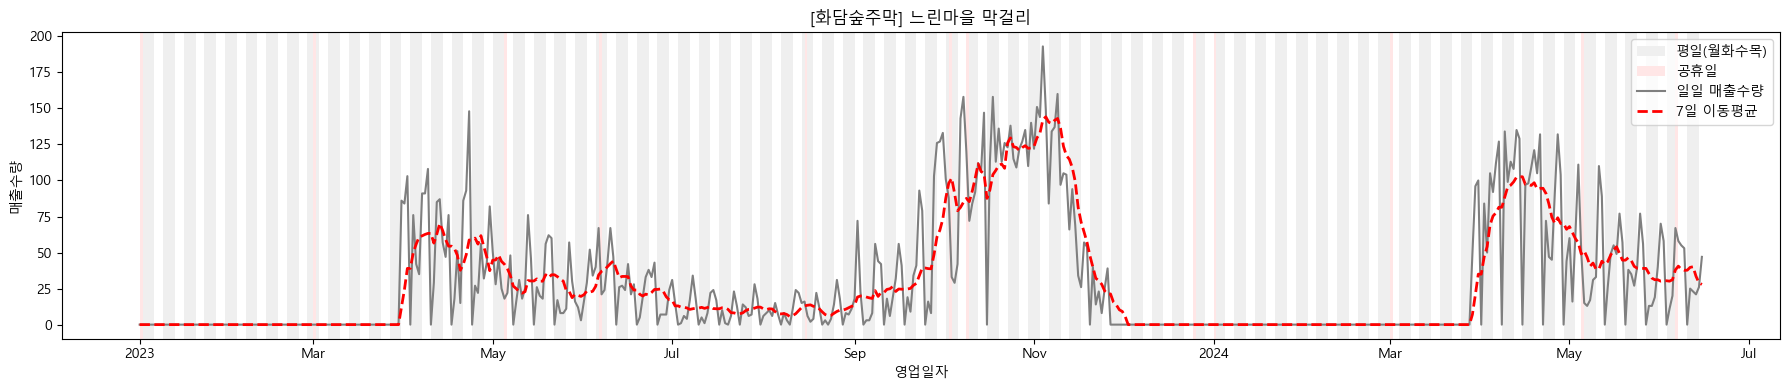

In [173]:
plot_venue("화담숲주막")

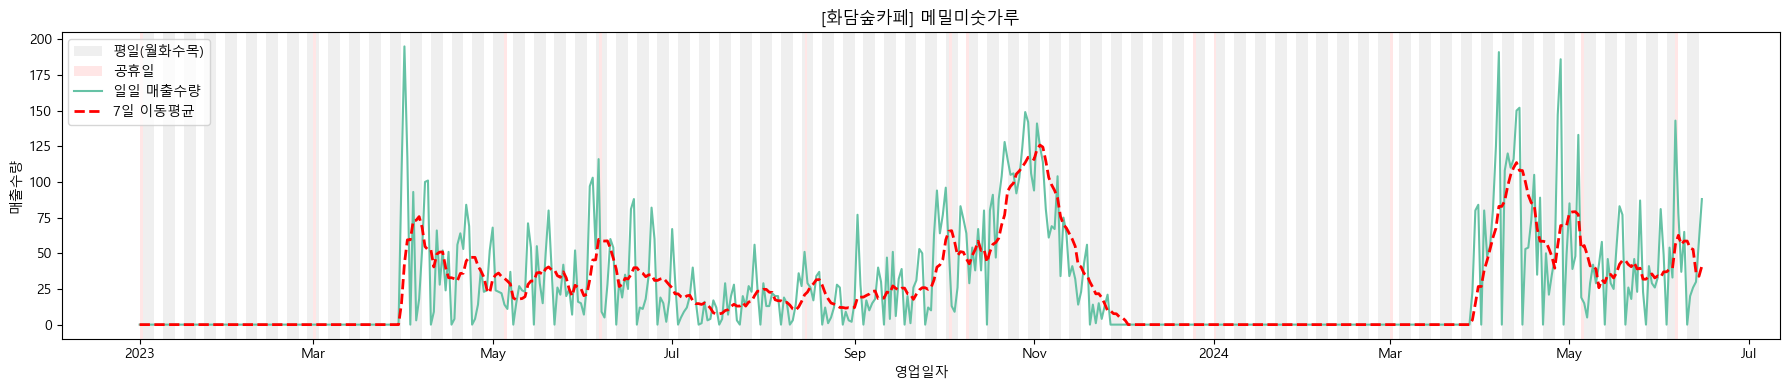

In [174]:
plot_venue("화담숲카페")